# 2D Leg Movement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## Forward Kinematics

We can express 2D Transformations as a 3-dimensional homogeneous transformation matrix

$$
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & x\\
\sin(\theta) & \cos(\theta) & y\\
0 & 0 & 1\\
\end{bmatrix}
$$

Where $\theta$ is the rotation angle and x,y are the components of the translation vector

In the following we use Spatial Maths for Python from Peter Corke as our Python module


### Reference

The following sources helped me to refine my understanding

<a href="http://faculty.salina.k-state.edu/tim/robot_prog/index.html" target="_blank">Robotics Programming Study Guide - Tim Bower</a>

<a href="https://www.youtube.com/watch?v=UpiRBNfK1f0" target="_blank">Describing rotation and translation in 2D - Peter Corke</a>

In [2]:
from spatialmath import *

In [3]:
# set parameters according 1-kinematics_2d
theta = np.radians(-135)
gamma = np.radians(80)
lu = 3
ll = 4

# set parameters according http://faculty.salina.k-state.edu/tim/robot_prog/Arm_robots/forwardKin.html#simple-2-d-example
#theta = np.pi*40/180
#gamma = -np.pi*15/180
#lu = 5
#ll = 2


In [4]:
# create 2d rotation Matrix for theta
R = SO2(theta)
print(R)

  -0.7071    0.7071    
  -0.7071   -0.7071    



In [5]:
# create a 2d homogeneous translation matrix
# calculate the translation vector
T = SE2([lu*np.cos(theta), lu*np.sin(theta)])
print(T)

   1         0        -2.121     
   0         1        -2.121     
   0         0         1         



In [6]:
# combining the two
T1 = SE2([lu*np.cos(theta), lu*np.sin(theta)]) * SE2(theta)
print(T1)

  -0.7071    0.7071   -2.121     
  -0.7071   -0.7071   -2.121     
   0         0         1         



   0.5736    0.8192    0.173     
  -0.8192    0.5736   -5.398     
   0         0         1         



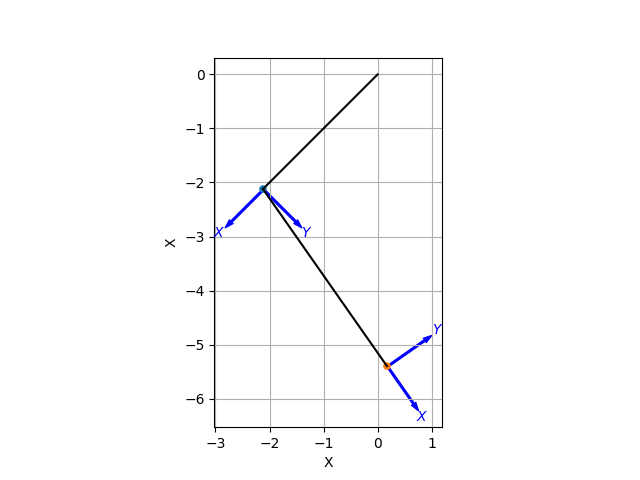

In [7]:
# Transforming from origin to end of upper leg to end of lower leg
T2 = SE2([ll*np.cos(gamma), ll*np.sin(gamma)]) * SE2(gamma)
T3 = T1*T2
print(T3)

points = np.zeros((2, 2))
fig, ax = plt.subplots()
# plot upper leg
points[0,1] = lu*np.cos(theta)
points[1,1] = lu*np.sin(theta)
plt.plot(points[0], points[1],'-k')
T1.plot()
# plot lower leg
points[0,0] = points[0,1]
points[1,0] = points[1,1]
points[0,1] = lu*np.cos(theta) + ll*np.cos(theta+gamma)
points[1,1] = lu*np.sin(theta) + ll*np.sin(theta+gamma)
plt.plot(points[0], points[1],'-k')
T3.plot()
plt.grid(True)

In [8]:
# for Minipupper write function for forward kinematic using only np
def transformationMatrix(angle, l):
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, -s, l*c], [s, c, l*s], [0, 0, 1]])
def mpForwardKin(angles):
    lu = 0.05022511821787979 # from urdf
    ll = 0.065 # measured, includes the rubber foot
    T1 = transformationMatrix(angles[0], lu)
    T2 = transformationMatrix(angles[1], ll)
    T3 = T1.dot(T2)
    P1 = T1.dot(np.array([0,0,1]))[0:2]
    P2 = T3.dot(np.array([0,0,1]))[0:2]
    return np.array([[0, P1[0], P2[0]], [0, P1[1], P2[1]]])

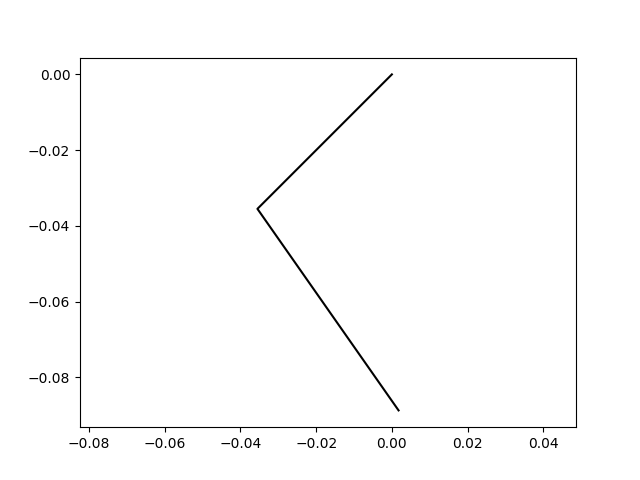

In [9]:
points = mpForwardKin([theta, gamma])
fig, ax = plt.subplots()
plt.plot(points[0], points[1],'-k')
plt.axis('equal')

plt.grid(visible=False, which='major')

## Inverse Kinematics

We use the calculations from 1-kinematics_2d

In [10]:
def mpInverseKin(point):
    lu = 0.05022511821787979 # from urdf
    ll = 0.065 # measured, includes the rubber foot
    gam = np.arccos((point[0]**2+point[1]**2-lu**2-ll**2)/(2*lu*ll))
    B = np.array(point)
    A11 = lu + ll * np.cos(gam)
    A12 = -ll * np.sin(gam)
    A21 = ll * np.sin(gam)
    A22 = lu + ll * np.cos(gam)

    A = np.array([[A11, A12], [A21, A22]])
    X = np.linalg.inv(A).dot(B)
    thet = np.arctan(X[1]/X[0])
    # correction for 2nd and 3rd quadrant
    # we assume -np.pi/4 <= thet <= -3*np.pi/4 
    if thet > -np.pi/4:
        thet = thet - np.pi
    return [thet, gam]

In [11]:
np.testing.assert_almost_equal([theta, gamma], mpInverseKin(mpForwardKin([theta, gamma])[:,2]), decimal=7, err_msg='', verbose=True)

In [12]:
for i in range(1,20):
    theta = -np.pi/4 - i/20 * np.pi
    gamma = i/20 * np.pi
    np.testing.assert_almost_equal([theta, gamma], mpInverseKin(mpForwardKin([theta, gamma])[:,2]), decimal=10, err_msg='', verbose=True)

## Push Up

We start with a neutral position and then draw a line up and down the y axes. On this line we define a number of points that must be reached, each point in a configurable time interval that is constant for all points.

We will take care that we can repeat this leg_servo_positions to build loops

In [13]:
theta = -3*np.pi/4
gamma = np.pi/2
midpoint = mpForwardKin([theta, gamma])[:,2]
# 
delta = 0.02 # how much up, down
N = 20 # number of points
line = np.linspace(midpoint[1]-delta, midpoint[1]+delta, num=N)

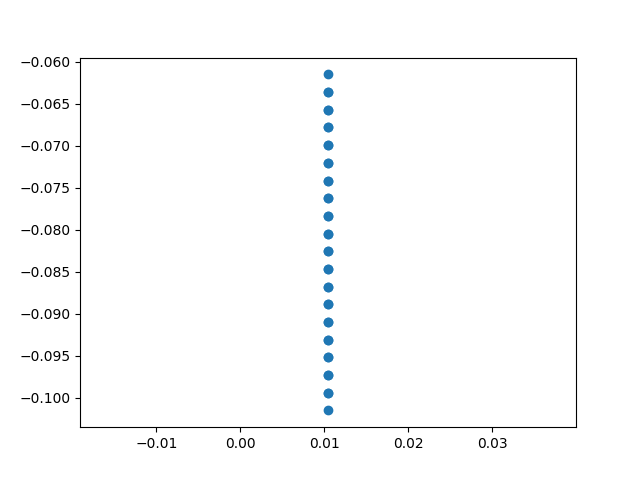

In [14]:
# create points there to position the foot. We construct a loop and make sure the end points are only hit once
points = np.full((2, 2*N-2), midpoint[0])
points[1][0:N] = line
points[1][N:] = np.flip(line)[1:N-1]

#plot
fig, ax = plt.subplots()
plt.scatter(points[0], points[1])
plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=False, which='major')

In [15]:
leg_servo_positions = []
for j in range(2*N-2):
    leg_servo_positions.append(mpInverseKin(points[:,j]))

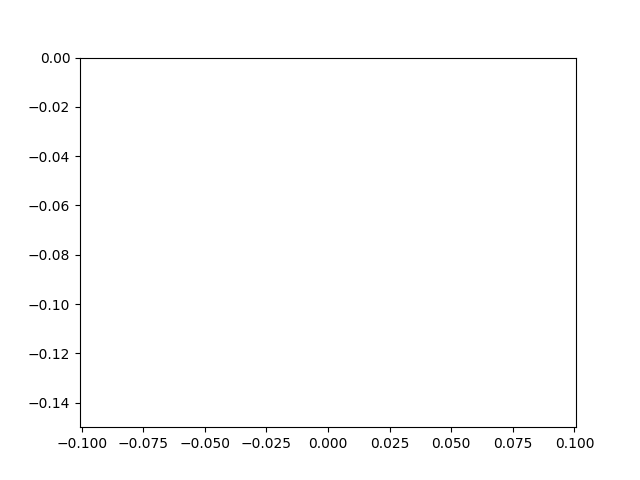

In [16]:
import matplotlib.animation as animation
from collections import deque

fig, ax = plt.subplots()
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0)
plt.axis('equal')
plt.grid(visible=False, which='major')

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], '.-', lw=1, ms=2)
step_template = 'step = %.1f'
step_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
history_len = 50
history_x, history_y = deque(maxlen=history_len), deque(maxlen=history_len)


def animate(i):
    p = mpForwardKin(leg_servo_positions[i])

    if i == 0:
        history_x.clear()
        history_y.clear()

    history_x.appendleft(p[0][2])
    history_y.appendleft(p[1][2])

    line.set_data(p[0], p[1])
    trace.set_data(history_x, history_y)
    step_text.set_text(step_template % (i))
    #step_text.set_text("%s" % (p[0]))
    return line, trace, step_text


ani = animation.FuncAnimation(fig, animate, len(leg_servo_positions), interval=200, blit=True)

plt.show()

## Deployment

We can deploy leg trajectories to a simulated or physical minipuper by writing angles to a file for each servo.

The controller in the simulated or physical environments reads all servo command files and finds the file with the most steps in it. This is the cycle length. You can specify the duration of one cycle by a parameter. 

In [17]:
# wite to disk

fh_hip = open("hip_servo", "w")
fh_upper_leg = open("upper_leg_servo", "w")
fh_lower_leg = open("lower_leg_servo", "w")
# hip will not move
fh_hip.write("%.10f\n" % 0.0)
for j in range(2*N-2):
    fh_upper_leg.write("%.10f\n" % leg_servo_positions[j][0])
    fh_lower_leg.write("%.10f\n" % leg_servo_positions[j][1])
fh_hip.close()
fh_upper_leg.close()
fh_lower_leg.close()

In [18]:
# Check

cycle_duration = 1 # duration in seconds

hip = []
with open("hip_servo", "r") as f:
    for line in f:
        hip.append(float(line.rstrip()))
upper_leg = []
with open("upper_leg_servo", "r") as f:
    for line in f:
        upper_leg.append(float(line.rstrip()))
lower_leg = []
with open("lower_leg_servo", "r") as f:
    for line in f:
        lower_leg.append(float(line.rstrip()))
        
max_steps = max(len(hip), len(upper_leg), len(lower_leg))

print("Duration per cycle: %s [msec]\nDuration per step: %s [msec]\nNumber of steps: %s" 
      % (cycle_duration*1000, cycle_duration*1000/max_steps, max_steps))

Duration per cycle: 1000 [msec]
Duration per step: 26.31578947368421 [msec]
Number of steps: 38


In [19]:
# copy files to controller
import shutil

joints = ['hip', 'upper_leg', 'lower_leg']
legs = ['lf', 'rf', 'lh', 'rh']

for joint in joints:
    for leg in legs:
        shutil.copy("./%s_servo" % joint, "../controller/servos/%s_%s" % (leg, joint))

In [20]:
# example how to control only front legs

for joint in joints:
    for leg in legs[2:]:
        with open("../controller/servos/%s_%s" % (leg, joint), "w") as f:
            angle = 0.0
            if 'upper' in joint:
                angle = -np.pi/4
            if 'lower' in joint:
                angle = np.pi/2
            f.write("%.10f\n" % angle)

In [21]:
# Save foot movements

for joint in joints:
    for leg in legs:
        shutil.copy("./%s_servo" % joint, "../controller/servos/pushup/%s_%s" % (leg, joint))